In [1]:
import sys
import numpy
import pickle
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None; 
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [2]:
%reload_ext autoreload
%autoreload 2
from run_inference import *
from postprocessing_functions import *

/Users/utkarsh/GitHub/P_NS/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mcmc = None
path = f"results/prior"
mcmc = pickle_read(path)
prior_samples = infer_samples(mcmc)

In [4]:
mcmc = None
path = f"results/posterior"
mcmc = pickle_read(path)
posterior_samples = infer_samples(mcmc)
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
             A[0]      0.14      0.57      0.20     -0.72      1.00   4032.72      1.00
       alpha_1[0]     -3.99      0.66     -4.07     -5.00     -3.12   1864.12      1.00
       alpha_2[0]     -0.30      0.53     -0.28     -1.19      0.51   1087.70      1.00
        beta_1[0]      1.29      2.20      1.41     -1.78      4.99   4132.76      1.00
        beta_2[0]      2.27      0.77      2.18      1.01      3.47   2103.46      1.00
      beta_gap[0]      1.04      0.49      1.02      0.26      1.85   3516.86      1.00
      eta_high[0]     25.06     14.28     24.99      4.65     49.04   7297.89      1.00
       eta_low[0]     24.84     14.45     24.74      0.52     45.41   4845.12      1.00
       eta_max[0]      4.48      2.75      4.28      0.00      8.52   3695.43      1.00
       eta_min[0]     30.51     11.67     30.66     13.89     49.77   6584.23      1.00
    gamma_high[0]      6.04    

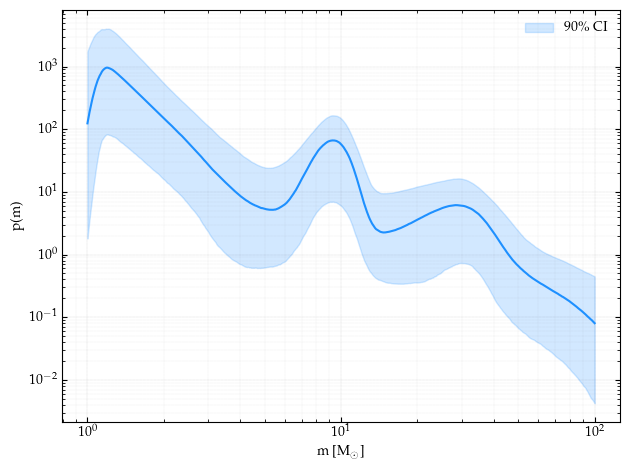

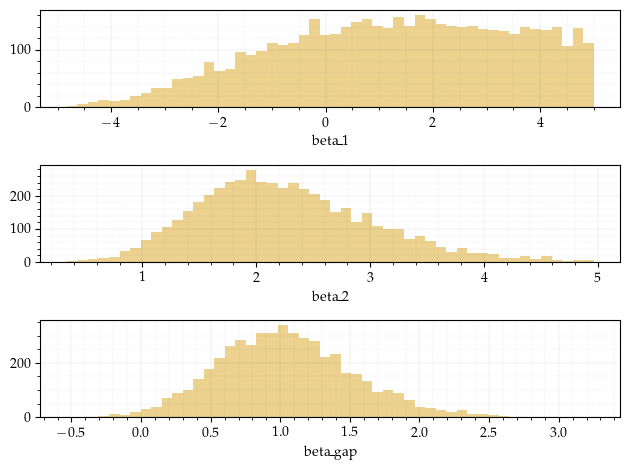

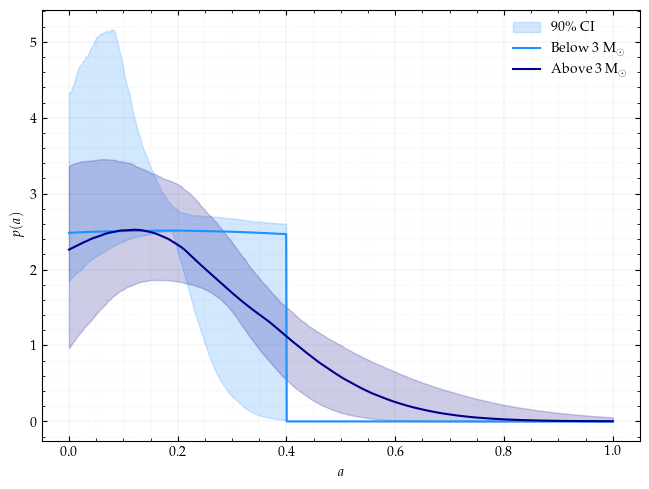

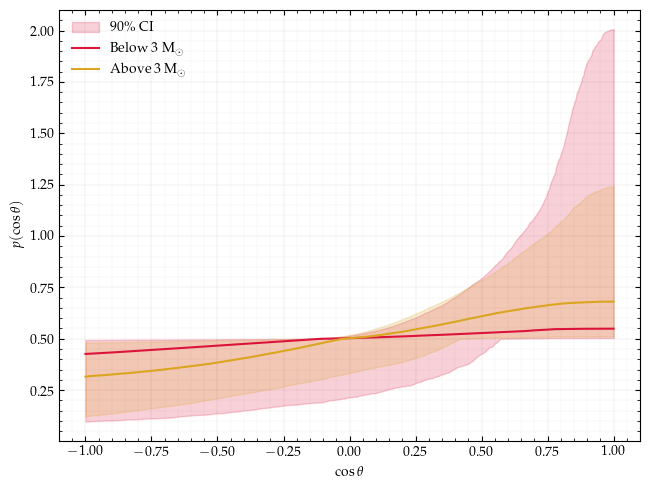

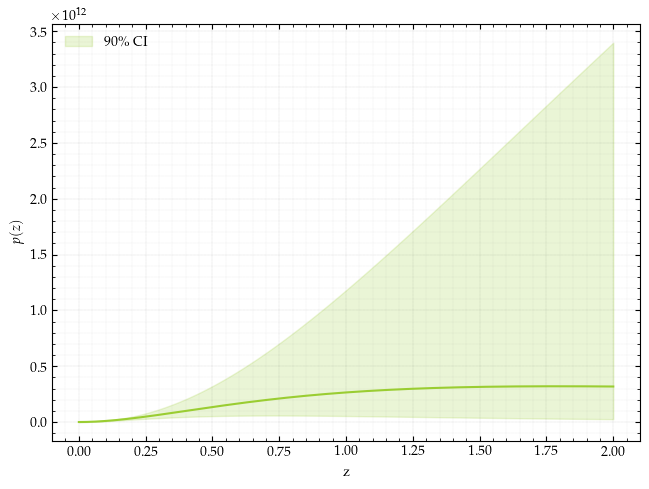

In [5]:
try:
    from config.mass1d_func import pdb_with_NG as mass1d_func
except:
    from config.mass1d_func import multi_pdb as mass1d_func
from config.spin_func import prob_chi, prob_costilt
from config.distance_func import powerlaw_redshift

plot_p_m(posterior_samples, function=mass1d_func)
plot_p_pairing(posterior_samples)
plot_p_chi(posterior_samples, function=prob_chi)
plot_p_costilt(posterior_samples, function=prob_costilt)
plot_p_z(posterior_samples, function=powerlaw_redshift)
plt.show()

In [6]:
import os
import arviz as az

if os.path.exists("results/trace1.png") or os.path.exists("results/trace2.png") or os.path.exists("results/trace.png"):
    print("Trace plots already exist, skipping generation")
else:
    print("Generating trace plots")
    data = az.from_numpyro(mcmc)
    var_names_lst = get_non_deterministic_params(mcmc)

    if len(var_names_lst) >= 20:
        cut1 = var_names_lst[:20]
        cut2 = var_names_lst[20:]

        assert len(cut1) + len(cut2) == len(var_names_lst)

        az.plot_trace(data, var_names=cut1, compact=True)
        plt.savefig("results/trace1.png")
        az.plot_trace(data, var_names=cut2, compact=True)
        plt.savefig("results/trace2.png")
    else:
        az.plot_trace(data, var_names=var_names_lst, compact=True)
        plt.savefig("results/trace.png")

Trace plots already exist, skipping generation


In [7]:
from model_vector import model_vector

import os

# try:
#     os.remove("results/postprocessed_samples")
# except: pass

if os.path.exists("results/postprocessed_samples"):
    with open("results/postprocessed_samples", "rb") as f:
        postprocessed_posterior_samples = pickle.load(f)
else:
    postprocessed_posterior_samples = add_postprocessing_effects(posterior_samples, model_vector)
    with open("results/postprocessed_samples", "wb") as f:
        pickle.dump(postprocessed_posterior_samples, f)

config = configparser.ConfigParser()
config.read('config/config.ini')
event_folder_name = config["DIRECTORIES"]["event_folder_name"]
event_file_name = config["DIRECTORIES"]["event_file_name"]
translate_dir = "../../"
events = numpy.loadtxt(translate_dir+event_folder_name+event_file_name, dtype=str)

for event_i in tqdm(range(len(postprocessed_posterior_samples["neff_events"].T))):
    neff = postprocessed_posterior_samples["neff_events"].T[event_i]
    filename = events[event_i][:14]
    plot_neff(neff, filename)
    plt.close()

100%|██████████| 66/66 [00:43<00:00,  1.52it/s]


/Users/utkarsh/GitHub/P_NS/sampler/runs/multiPDB_betaSplit3_brokenG_1_full/postprocessing_functions.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  def utkarshWrapper(): plt.legend();plt.utkarshGrid();plt.gca().tick_params(direction='in', which='both', right=True,


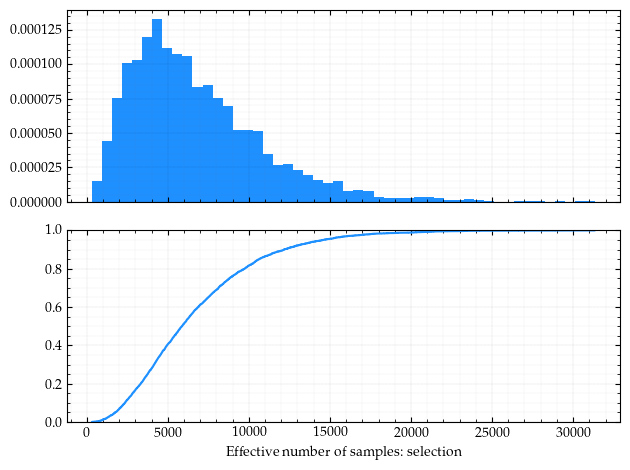

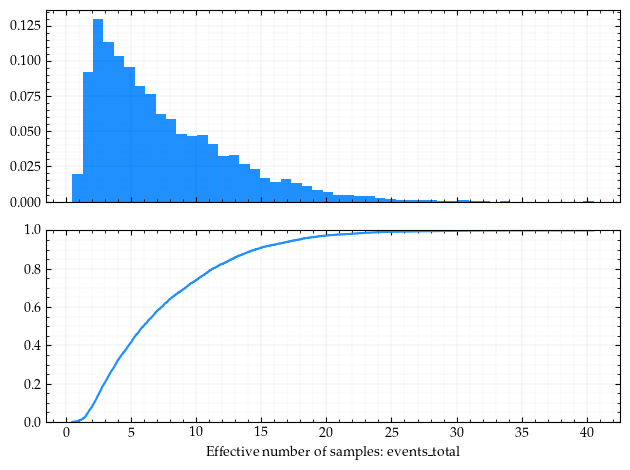

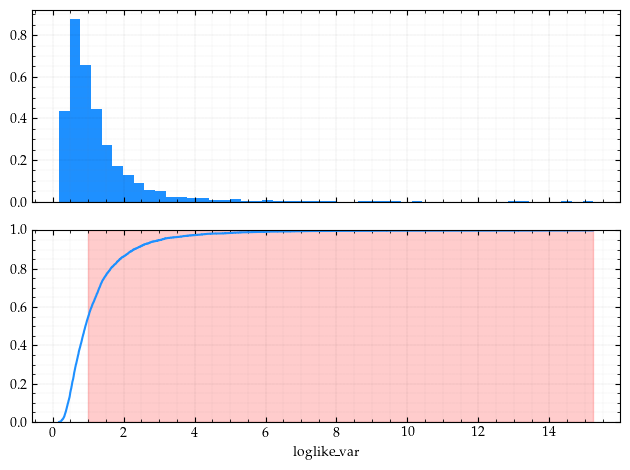

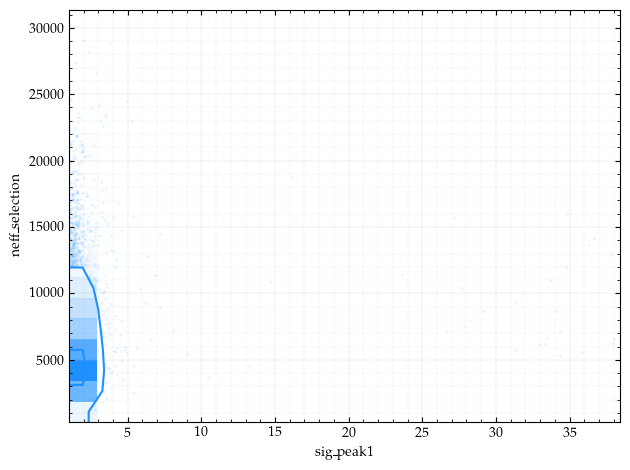

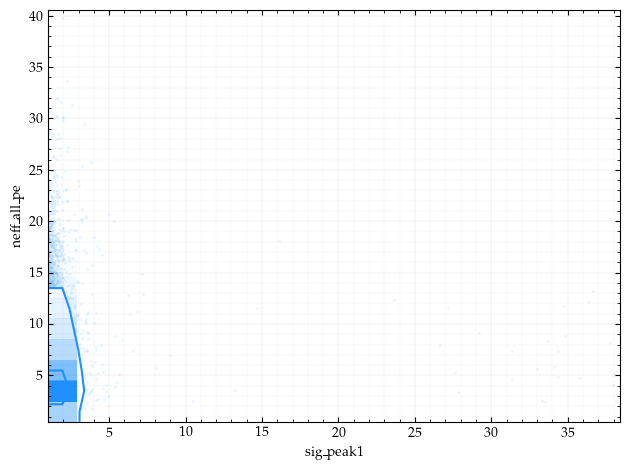

In [8]:
plot_neff(postprocessed_posterior_samples["neff_selection"], "selection")
plot_neff(postprocessed_posterior_samples["neff_events_total"], "events_total")
plot_neff(postprocessed_posterior_samples["loglike_var"], "loglike_var")
plt.xlabel("loglike_var")
plt.axvspan(1, max(postprocessed_posterior_samples["loglike_var"]), color = "red", label = "Var samples greater than 1", alpha = 0.2)
plt.savefig("results/loglike_var.png")

plt.figure()
plot_corner(postprocessed_posterior_samples["sig_peak1"], postprocessed_posterior_samples["neff_selection"], "sig_peak1", "neff_selection")
plt.figure()
plot_corner(postprocessed_posterior_samples["sig_peak1"], postprocessed_posterior_samples["neff_events_total"], "sig_peak1", "neff_all_pe")

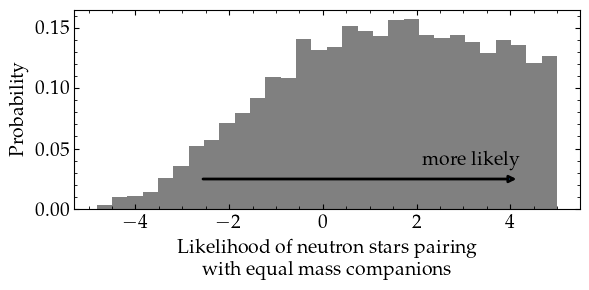

In [52]:
beta_NS = posterior_samples["beta_1"]

FONTSIZE = 14

plt.figure(figsize=(6, 3))
plt.hist(beta_NS, bins=30, color = "grey", density=True)
ax = plt.gca()
ax.tick_params(direction="in", which="both", right = True, top = True,labelsize=FONTSIZE)
ax.minorticks_on()

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

# Horizontal right-facing arrow glued to the bottom of the axes
xbase = 0.15
ax.annotate(
    "", xy=(0.88, xbase), xytext=(0.25, xbase),
    xycoords=ax.transAxes, textcoords=ax.transAxes,
    arrowprops=dict(arrowstyle="-|>", lw=2),
    annotation_clip=False, zorder=5
)

# Separate label on the right, just above the arrow
ax.text(
    0.88, xbase+0.04, "more likely",
    transform=ax.transAxes,
    ha="right", va="bottom", fontsize=FONTSIZE
)

plt.ylabel("Probability", fontsize=FONTSIZE)
plt.xlabel("Likelihood of neutron stars pairing\nwith equal mass companions", fontsize=FONTSIZE)
plt.savefig("pairingBNS.png", dpi = 300)
plt.show()